In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from pandas.plotting import scatter_matrix

Step 1: Loading data & testing/training split from Project 1

In [2]:
url = 'https://raw.githubusercontent.com/arianacodes/project-1/main/player_shooting_2023_2024.csv'
df = pd.read_csv(url, index_col=0)
#dropping columns that are repetative or not correlated: 
df = df.drop(['Age', 'Nation','Birth Month','Matches'],axis=1)
df = df[df['Squad'] != 'Squad']                           #removing rows that contained no data

#One Hot Encoding position and team
pos_array = pd.get_dummies(df.Pos)
squad_array = pd.get_dummies(df.Squad)
df = pd.concat([df,pos_array], axis=1)
df = pd.concat([df,squad_array], axis=1)
df = df.drop(['West Ham','GK','Pos','Squad'],axis=1) #dropping one and respective column (*2)

df['Exceeded xG'] = np.where(df['G-xG'] > 0, 1, 0)  #creating binary target attribute
df = df.drop(['Gls','xG','PK','FK','G/Sh','npxG'],axis=1)    #dropping correlated variables

X = df.drop(columns=['Player', 'G-xG'])
y = df['G-xG']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

In [ ]:
Step 2: Preparing data. 

In [3]:
#preforming smoothing to 0 values
X_train = X_train.replace(np.nan, 0)
X_train[['SoT%','PKatt']] = X_train[['SoT%','PKatt']] + 0.1
X_train[['Sh','SoT','SoT/90','Sh/90']] = X_train[['Sh','SoT','SoT/90','Sh/90']] + 0.1

#Performing log feature scaling to have more Gaussian distributions
transformed = X_train[['Sh','SoT','Sh/90','SoT/90']].transform(lambda x: np.log(x))

X_train = X_train.drop(['Sh','SoT','Sh/90','SoT/90'],axis=1)
X_train = pd.concat([X_train, transformed], axis=1)

#doing the same thing to X_test
#preforming smoothing to 0 values
X_test = X_test.replace(np.nan, 0)
X_test[['SoT%','PKatt']] = X_test[['SoT%','PKatt']] + 0.1
X_test[['Sh','SoT','SoT/90','Sh/90']] = X_test[['Sh','SoT','SoT/90','Sh/90']] + 0.1

#Performing log feature scaling to have more Gaussian distributions
transform = X_test[['Sh','SoT','Sh/90','SoT/90']].transform(lambda x: np.log(x))

X_test = X_test.drop(['Sh','SoT','Sh/90','SoT/90'],axis=1)
X_test = pd.concat([X_test, transform], axis=1)

print(X_test.head())
print(X_train.head())

      Rk    Born   90s  SoT%  G/SoT  Dist  PKatt  npxG/Sh  np:G-xG     DF  \
507  489  1994.0  20.6  37.1   0.35  13.9    0.1     0.13     -0.1  False   
475  458  2001.0  31.0  25.1   1.00  11.0    0.1     0.19      0.5   True   
426  411  2004.0   0.1   0.1   0.00   0.0    0.1     0.00      0.0  False   
89    87  1991.0  15.4  40.1   0.17  20.4    0.1     0.07      0.0  False   
347  335  1996.0   4.6   0.1   0.00  10.8    0.1     0.10     -0.2   True   

     ...  Newcastle Utd  Nott'ham Forest  Sheffield Utd  Tottenham  Wolves  \
507  ...          False            False          False      False   False   
475  ...          False            False          False      False   False   
426  ...          False            False           True      False   False   
89   ...          False            False          False      False   False   
347  ...          False             True          False      False   False   

     Exceeded xG        Sh       SoT     Sh/90    SoT/90  
507      

Step 3: I examine my target attribute: G-xG and after trying out all the possible transformations, not transforming it results in a less Gaussian distribution so I leave it as is.

<Axes: >

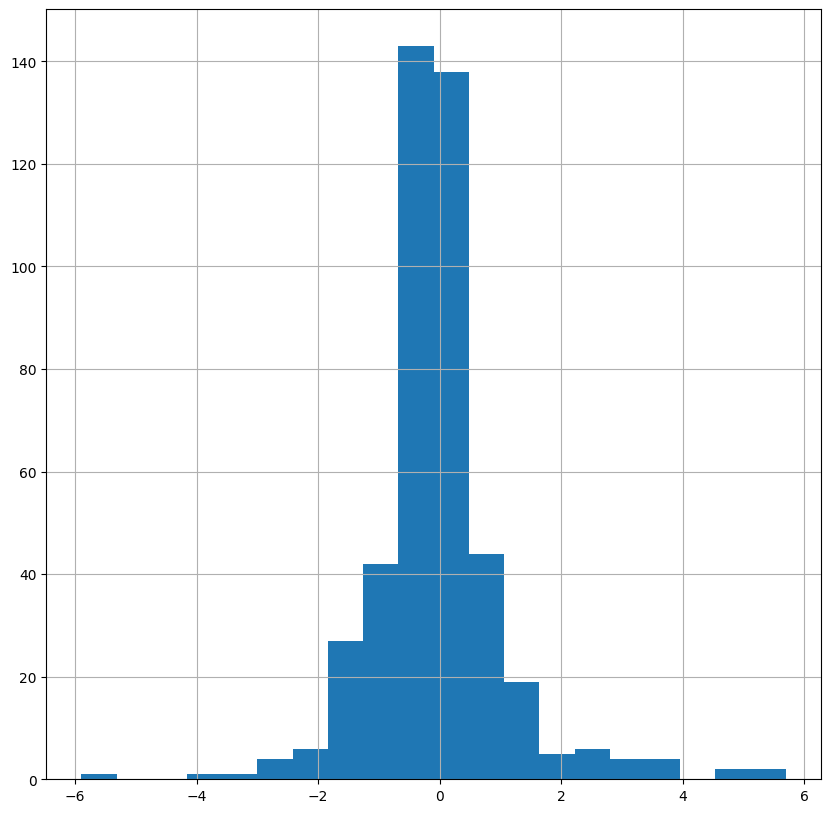

In [4]:
y_train.hist(bins = 20, figsize = (10,10))

Step 4: I am selecting Linear Regression and SVM

Step 5: Here I run my two models, Lasso and SVR. I don't calculate precision, recall and F1 because I am not performing a binary classification. Below I report best and worst parameter settings for each model.

In [5]:
model = SVR(C=1)
model.fit(X_train, y_train)

SVR(C=1)

<Axes: xlabel='G-xG', ylabel='G-xG'>

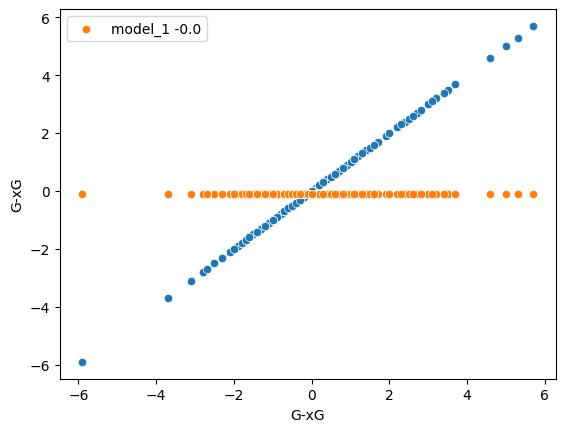

In [6]:
import seaborn as sns
sns.scatterplot(y= y_train, x= y_train)
sns.scatterplot(y=model.predict(X_train), x = y_train, label = f'model_1 {model.score(X_train, y_train).round(2)}')

In [8]:
p_grid = {'kernel' : ['linear','poly','rbf','sigmoid'],
         'degree' : np.arange(1,6),
         'C': np.logspace(-3,3,7)}
grid = GridSearchCV(model,param_grid=p_grid, cv = 5)
grid

GridSearchCV(cv=5, estimator=SVR(C=1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'degree': array([1, 2, 3, 4, 5]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [9]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(C=1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'degree': array([1, 2, 3, 4, 5]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [38]:
pd.DataFrame(grid.cv_results_).iloc[:,4:].sort_values('rank_test_score')

,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
56,0.1,5,linear,"{'C': 0.1, 'degree': 5, 'kernel': 'linear'}",9.355657e-01,0.990971,9.424982e-01,0.981237,0.978642,9.657827e-01,0.022333,1
52,0.1,4,linear,"{'C': 0.1, 'degree': 4, 'kernel': 'linear'}",9.355657e-01,0.990971,9.424982e-01,0.981237,0.978642,9.657827e-01,0.022333,1
48,0.1,3,linear,"{'C': 0.1, 'degree': 3, 'kernel': 'linear'}",9.355657e-01,0.990971,9.424982e-01,0.981237,0.978642,9.657827e-01,0.022333,1
44,0.1,2,linear,"{'C': 0.1, 'degree': 2, 'kernel': 'linear'}",9.355657e-01,0.990971,9.424982e-01,0.981237,0.978642,9.657827e-01,0.022333,1
40,0.1,1,linear,"{'C': 0.1, 'degree': 1, 'kernel': 'linear'}",9.355657e-01,0.990971,9.424982e-01,0.981237,0.978642,9.657827e-01,0.022333,1
...,...,...,...,...,...,...,...,...,...,...,...,...
124,1000.0,2,linear,"{'C': 1000.0, 'degree': 2, 'kernel': 'linear'}",-2.953456e+06,-919098.672383,-2.872922e+06,-993216.373931,-840166.014522,-1.715772e+06,979215.857682,136
128,1000.0,3,linear,"{'C': 1000.0, 'degree': 3, 'kernel': 'linear'}",-2.953456e+06,-919098.672383,-2.872922e+06,-993216.373931,-840166.014522,-1.715772e+06,979215.857682,136
120,1000.0,1,linear,"{'C': 1000.0, 'degree': 1, 'kernel': 'linear'}",-2.953456e+06,-919098.672383,-2.872922e+06,-993216.373931,-840166.014522,-1.715772e+06,979215.857682,136
132,1000.0,4,linear,"{'C': 1000.0, 'degree': 4, 'kernel': 'linear'}",-2.953456e+06,-919098.672383,-2.872922e+06,-993216.373931,-840166.014522,-1.715772e+06,979215.857682,136


*The best performing parameter settings were: C=0.1, degree=1, kernel='linear'. The two worst were: C=1000, degree=4 or 5, and kernel='linear'.

In [34]:
grid.best_estimator_

SVR(C=0.1, degree=1, kernel='linear')

In [35]:
grid.best_score_

0.9657826888512157

<Axes: xlabel='G-xG', ylabel='G-xG'>

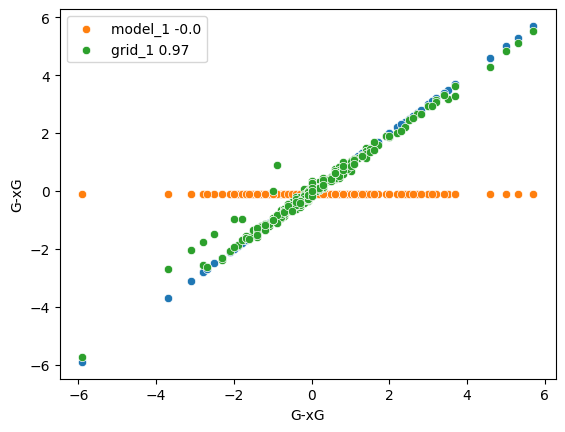

In [36]:
sns.scatterplot(y= y_train, x= y_train)
sns.scatterplot(y=model.predict(X_train), x = y_train, label = f'model_1 {model.score(X_train, y_train).round(2)}')
sns.scatterplot(y=grid.predict(X_train), x = y_train, label = f'grid_1 {grid.score(X_train, y_train).round(2)}')

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=5)
reg = linear_model.Lasso()
reg.fit(X_train, y_train)

# calculating RMSE
from sklearn.metrics import root_mean_squared_error
y_pred = reg.predict(X_test)
print(root_mean_squared_error(y_test, y_pred))

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

0.9253999666639863
0.5893808635174385


In [16]:
reg.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [19]:
hyperParameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
LassoRegressor = GridSearchCV(reg, hyperParameters, scoring='neg_mean_squared_error', cv=5)
LassoRegressor.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error')

In [20]:
pd.DataFrame(LassoRegressor.cv_results_).iloc[:,4:].sort_values('rank_test_score')

,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.001,{'alpha': 0.001},-0.045509,-0.010359,-0.057676,-0.012853,-0.026508,-0.030581,0.018422,1
4,0.01,{'alpha': 0.01},-0.056589,-0.008815,-0.052668,-0.010305,-0.027106,-0.031097,0.020297,2
2,0.0,{'alpha': 1e-08},-0.046898,-0.011459,-0.058895,-0.015505,-0.026776,-0.031907,0.018257,3
1,0.0,{'alpha': 1e-10},-0.046898,-0.011459,-0.058895,-0.015505,-0.026776,-0.031907,0.018257,4
0,0.0,{'alpha': 1e-15},-0.046898,-0.011459,-0.058895,-0.015505,-0.026776,-0.031907,0.018257,5
5,1,{'alpha': 1},-0.423802,-1.580040,-0.940815,-0.714792,-1.284627,-0.988815,0.408334,6
8,20,{'alpha': 20},-0.673500,-1.670725,-1.208293,-0.996601,-1.465105,-1.202845,0.349418,7
9,30,{'alpha': 30},-0.673500,-1.670725,-1.208293,-0.996601,-1.465105,-1.202845,0.349418,7
10,35,{'alpha': 35},-0.673500,-1.670725,-1.208293,-0.996601,-1.465105,-1.202845,0.349418,7
11,40,{'alpha': 40},-0.673500,-1.670725,-1.208293,-0.996601,-1.465105,-1.202845,0.349418,7


The best alpha value for our model was 0.001, and the worst alpha value was 5.

<Axes: xlabel='G-xG', ylabel='G-xG'>

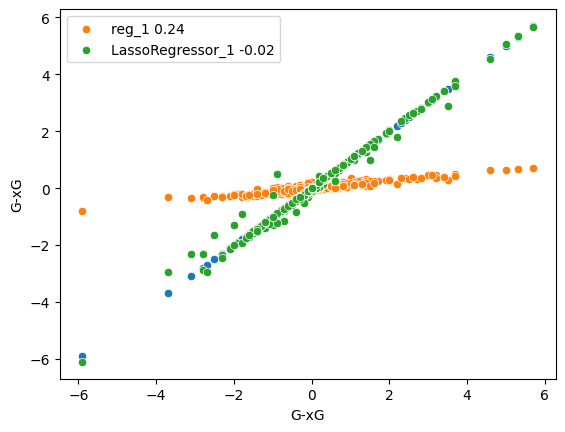

In [21]:
sns.scatterplot(y= y_train, x= y_train)
sns.scatterplot(y=reg.predict(X_train), x = y_train, label = f'reg_1 {reg.score(X_train, y_train).round(2)}')
sns.scatterplot(y=LassoRegressor.predict(X_train), x = y_train, label = f'LassoRegressor_1 {LassoRegressor.score(X_train, y_train).round(2)}')

Maybe I'm doing something wrong. My SVM model has a long runtime when using cross_val_score and my Lasso regressor did not converge. This is strange because I thought they had a 

In [25]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
cv_scores = cross_val_score(LassoRegressor, X, y, cv=kf)

/Users/arianamaisonet/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e-01, tolerance: 4.450e-02
  model = cd_fast.enet_coordinate_descent(


In [ ]:
cv_scores = cross_val_score(grid, X, y, cv=kf)